In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F


from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [2]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss


               avg_load
date                   
2015-12-01  78053.08333
2015-12-02  80366.62500
2015-12-03  81614.33333
2015-12-04  81098.83333
2015-12-05  75693.37500
445
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=72, forecast_length=3, share_thetas=False) at @2828023835144
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=72, forecast_length=3, share_thetas=False) at @2828023835144
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=72, forecast_length=3, share_thetas=False) at @2828023835144
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=3, backcast_length=72, forecast_length=3, share_thetas=True) at @2827999576328
     | -- SeasonalityBlock(units=64, thetas_dim=3, backcast_length=72, forecast_length=3, share_thetas=True) at @2827999576328
     | -- SeasonalityBlock(units=64, thetas_dim=3, backcast_length=72, forecas

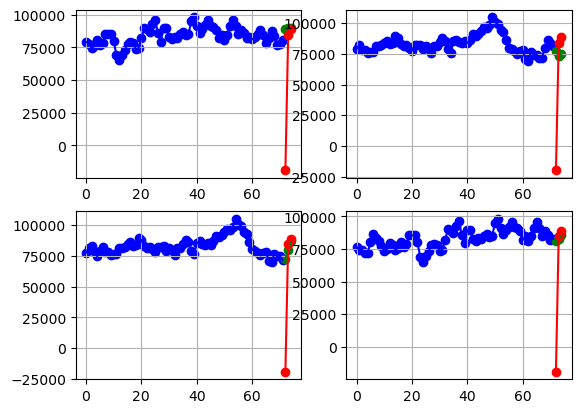

epoch = 0000, grad_step = 000028, tr_loss (epoch) = 513.623, te_loss (epoch) = 310.832


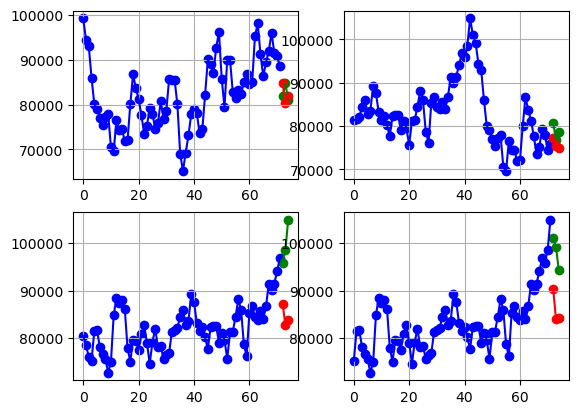

epoch = 0100, grad_step = 002828, tr_loss (epoch) = 3.008, te_loss (epoch) = 5.536


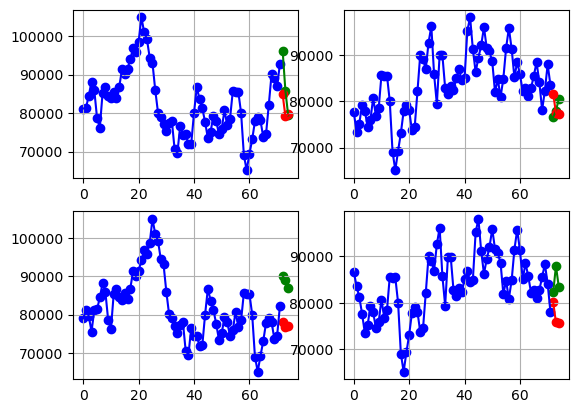

epoch = 0200, grad_step = 005628, tr_loss (epoch) = 2.503, te_loss (epoch) = 4.919


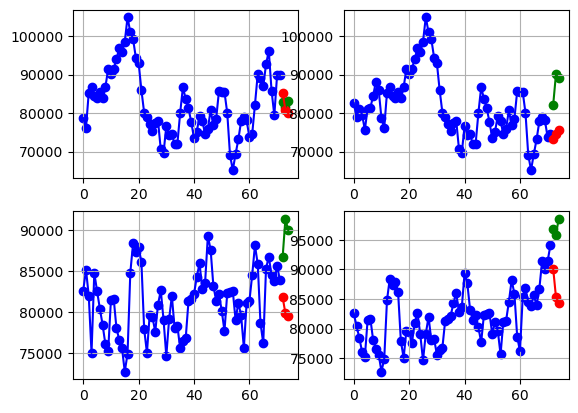

epoch = 0300, grad_step = 008428, tr_loss (epoch) = 2.056, te_loss (epoch) = 4.656


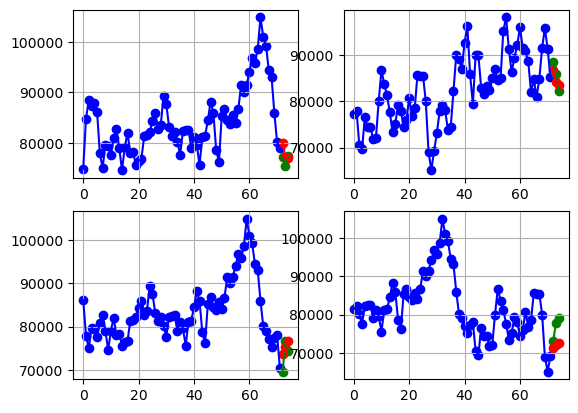

epoch = 0400, grad_step = 011228, tr_loss (epoch) = 1.883, te_loss (epoch) = 6.055


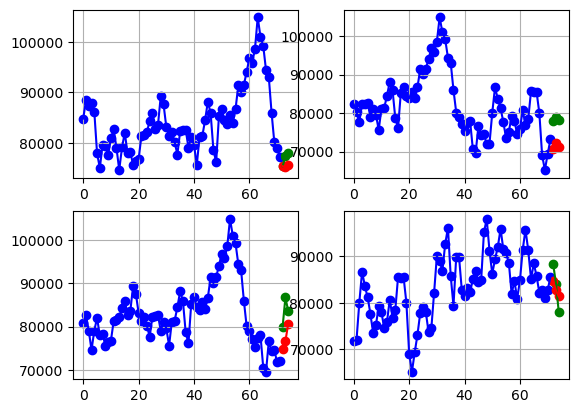

epoch = 0500, grad_step = 014028, tr_loss (epoch) = 1.448, te_loss (epoch) = 6.967


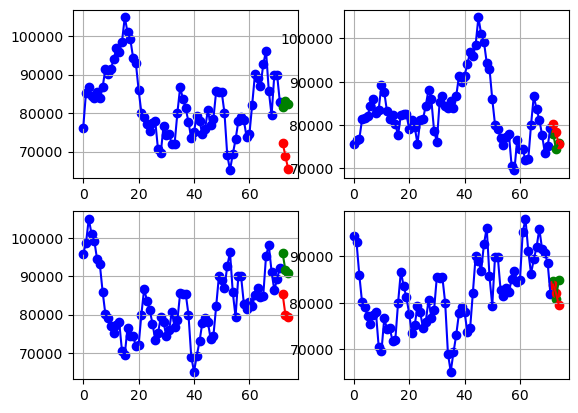

epoch = 0600, grad_step = 016828, tr_loss (epoch) = 1.086, te_loss (epoch) = 6.545


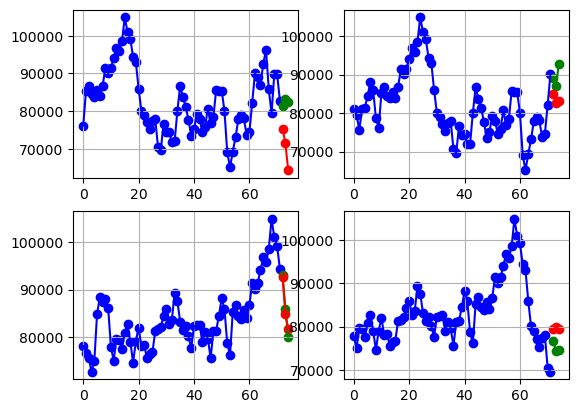

epoch = 0700, grad_step = 019628, tr_loss (epoch) = 1.309, te_loss (epoch) = 5.397


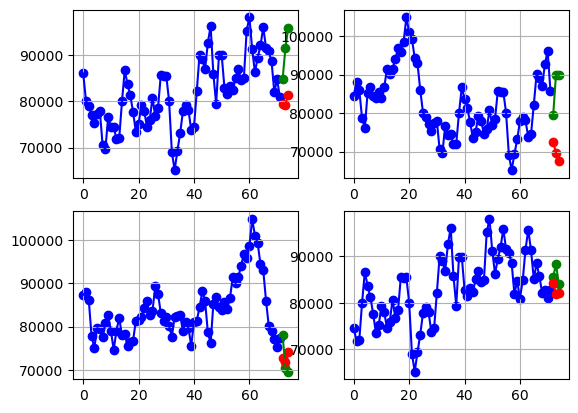

epoch = 0800, grad_step = 022428, tr_loss (epoch) = 0.940, te_loss (epoch) = 8.814


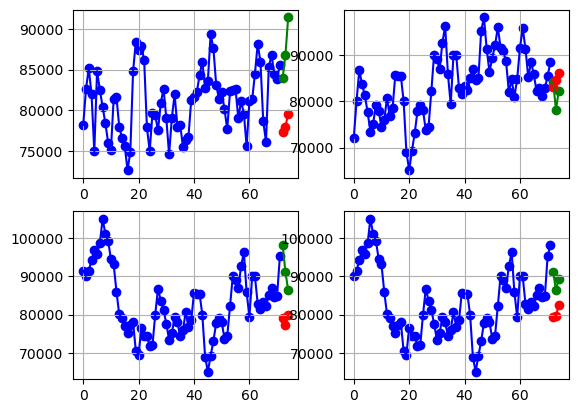

epoch = 0900, grad_step = 025228, tr_loss (epoch) = 1.283, te_loss (epoch) = 5.181


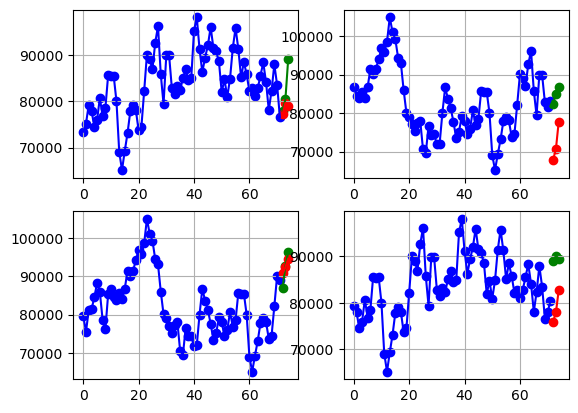

epoch = 1000, grad_step = 028028, tr_loss (epoch) = 0.794, te_loss (epoch) = 5.378


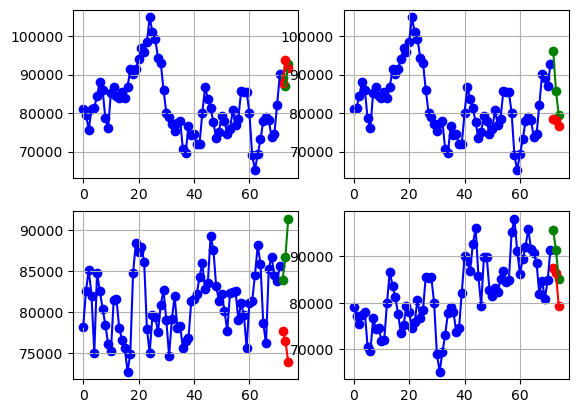

epoch = 1100, grad_step = 030828, tr_loss (epoch) = 0.575, te_loss (epoch) = 5.437
Text [81849.4921875, 76269.734375, 76600.546875, 76486.75, 76047.3125, 75091.46875, 76414.8046875, 79534.3984375, 78517.4609375, 77523.28125, 79676.8203125, 79944.234375, 76462.3359375, 77473.4375, 78493.59375, 76316.0234375, 75260.6796875, 75207.890625, 78329.34375, 73182.40625, 74946.09375, 79136.5078125, 81781.9921875, 79188.6328125, 78010.703125, 80296.828125, 78791.5078125, 78695.8828125]
TRU [80935.66667 84849.83333 91480.33333 95783.33333 91291.70833 85139.
 88489.125   85795.91667 82187.04167 82856.625   81152.08333 82769.95833
 85539.75    88357.75    84167.79167 78098.54167 82283.      87944.95833
 83520.5     76619.91667 77946.91667 80435.875   89059.95833 90162.625
 89529.5     83474.375   77997.33333 80903.20833]
TRU 28
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
28 天总共预测电量的mape的平均值
mape : 0.08
mape % : 8.04 %
---------------------------------------------
[1.129076407347018, 10.112098772

In [14]:
def main():
    forecast_length = 3
    backcast_length = 72
    # backcast_length = forecast_length*7
    batch_size = 16  # greater than 4 for viz

    electric = pd.read_csv('data/USA/usa whole_avg - Copy.csv', index_col=0, parse_dates=True)

    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.TREND_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        # nb_blocks_per_stack=4,
        hidden_layer_units = 64,
        thetas_dim=(8,8,3),
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    # optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    # best_state_dict = None
    # best_loss = float('inf')
    for epoch in range(1200):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            A=CustomLoss()
            # loss = A(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        B=CustomLoss()
        # test_loss = B(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)

            # if test_loss < best_loss:
            #     best_loss = test_loss
            #     # best_state_dict = nbeats.state_dict()
            #     best_state_dict = net.state_dict()


            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant
    NC = C.detach().numpy()
    NNC = NC.tolist()
    Text=NNC[len(NNC)-28::]
    print('Text',Text)
    #
    # B=forecast_length -1
    # avg=[]
    # # 当len（forecast）< forecast_length
    # if  forecast_length>len(forecast):
    #    for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:B])
    #          avg.append(N)
    #          pass
    #
    #       elif forecast_length-1>=i>len(forecast)-1:
    #          avg.append(np.mean(NNC[i:forecast_length * i + 1:B]))
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + B * j:len(NNC):B]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * B ])
    #          pass
    #    pass
    #
    # # 当len（forecast）= forecast_length
    # elif forecast_length == len(forecast):
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i :forecast_length * i + 1 : B])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + B * j:len(NNC):B]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * B ])
    #          pass
    #     pass
    #
    # # 当len（forecast）> forecast_length
    # else:
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=forecast_length-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:B])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast)>i>forecast_length-1:
    #          t = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + B * t : len(NNC) - (len(forecast)-i) * forecast_length + 1 : B]))
    #          pass
    #
    #       # 在这里下端触底了
    #       elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + B * j:len(NNC) - 1 : B]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * B ])
    #          pass
    #     pass
    #
    # print('avg',avg)
    # print(type(avg))
    # print('len(avg)',len(avg))
    #
    # Text=avg[len(avg)-28::]
    # print('Text',Text)


    TRU = electric[len(electric)-28::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))






    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'N-BEATS(usa_winter6).pth')









if __name__ == '__main__':
    main()